# Using Amazon Transcribe and Comprehend to analyze historical speeches

On this tutorial we are going to use tools for Natural Language Processing (NLP) to analyze historical videos from Youtube.
We are going to use [Youtube-DL](https://github.com/ytdl-org/youtube-dl/blob/master/README.md#readme) to download the files and Amazon Web Services (AWS) NLP tools through the [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) library.

In [1]:
# Libraries used on the tutorial
from __future__ import print_function
import boto3
import os
import time
import pandas as pd
import matplotlib as plt
import logging
from botocore.exceptions import ClientError
from datetime import date
import json
import seaborn as sns
import spacy


%matplotlib inline

## List of selected speeches
We are going to analyze 5 recorded speeches that are publicly available on Youtube:

A) [Winston Churchill, "We Shall Fight on the Beaches"](https://www.youtube.com/watch?v=s_LncVnecLA)<br>
In July the 4th of 1940 Winston Churchill went to the House of Commons to deliver one of the most courageous and important speeches in history. Europe was being rapidly conquered by the German army and France has already fallen into Hitler's control, and the British army had to retreat from the battle of Dunkirk. So Churchill invokes the British people to fight the Nazi menace discarding any cahnce of surrender, becoming the point of inflection in the history of World War II.

B) [Ronald Reagan, "Remarks at the Brandenburg Gate"](https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s)<br>
Former US president Ronald Reagan showed the world his sense of leadership and freedom when by the Brandeburg Gate in June the 12th of 1987, side by side with the Soviet leader Mikhail Gorbachov, he calls for an end to Cold War.

C) [Martin Luther King Jr., "I Have a Dream"](https://www.youtube.com/watch?v=I47Y6VHc3Ms)<br>
Minister Martin Luther King Jr. was the main leader of the Civil Rights movement that happened in the 50's and 60's in the US. During the March on Washington in 1963, he delivered his famous "I have a dream" speech claiming for peace and respect between whites and blacks the US.

D) [General Douglas MacArthur, "Duty, Honor, Country"](https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s)<br>
Few Americans in history have come close to General Douglas MacArthur when it comes to military life achievements.  Having fought in more than three wars, he embodied the figure of duty and honor for a military leader. His final speech at West Point Academy is an ode to patriotism and to soldiers that have died in the name of freedom.

E) [John F. Kennedy, "The Decision to Go to the Moon"](https://www.youtube.com/watch?v=QAmHcdwKgtQ)<br>
Former US President John F. Kennedy was of the greatest speakers in modern history and during an event in May the 25th of 1961 in Houston he communicated the nation and the world the goal for America to go to the moon. Few times in our history a project this massive have impacted so much science and modern society as the space race and moon landing.



## 1) Downloading the audio files from Youtube
First, we are going to download the audio files from Youtube using Youtube-DL.
You can easily install it using pip or conda package managers.

```sudo pip install youtube-dl```<br>
or<br>
```conda install -c conda-forge youtube-dl```


To download the file of any Youtube video you simply run on your terminal:

```youtube-dl <video_url>```<br>

As we only need the audio for our analysis, we can specify the parameters ```-x``` and ```--audio-format "mp3"``` to download the audio files 

```youtube-dl -x --audio-format "mp3" <video_url>```

In [2]:
# Create a dictionary with the URLs for each speech on Youtube
dict_urls_youtube = {
    'churchill': 'https://www.youtube.com/watch?v=s_LncVnecLA',
    'reagan': 'https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s',
    'luther_king': 'https://www.youtube.com/watch?v=I47Y6VHc3Ms',
    'macarthur': 'https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s',
    'kennedy': 'https://www.youtube.com/watch?v=QAmHcdwKgtQ'}

In [7]:
# Download each speech in mp3 format using Youtube-DL
for url in list(dict_urls_youtube.values()):
    print(f'Downloading audio file from the link: {url}')
    os.system(f'youtube-dl -x --audio-format "mp3" {url}')

In [9]:
# Create a Dataframe to store the information trough the analysis
df_audio = pd.DataFrame.from_dict(dict_urls_youtube, orient='index', columns=['youtube_urls'])
df_audio

,youtube_urls
churchill,https://www.youtube.com/watch?v=s_LncVnecLA
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ


In [10]:
# Linking the name of each audio file to the speaker
for audio_file in os.listdir('.'):
    if 'churchill' in audio_file.lower():
        df_audio.at['churchill','filename'] = audio_file
    elif 'reagan' in audio_file.lower():
        df_audio.at['reagan', 'filename'] = audio_file
    elif 'king' in audio_file.lower():
        df_audio.at['luther_king', 'filename'] = audio_file
    elif 'macarthur' in audio_file.lower():
        df_audio.at['macarthur', 'filename'] = audio_file
    elif 'kennedy' in audio_file.lower():
        df_audio.at['kennedy', 'filename'] = audio_file

In [11]:
df_audio

,youtube_urls,filename
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...
luther_king,https://www.youtube.com/watch?v=I47Y6VHc3Ms,Martin Luther King _ 'I Have A Dream' Speech-I...
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,"Duty, Honor, Country _ Douglas MacArthur _ May..."
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...


### Configuring AWS using the terminal
To use boto3 you first need to install the ```awscli```
```
$ pip install awscli --upgrade --user
```

Next step is to use your aws credentials to configure ```awscli``` by typing:

```
aws configure
```

And define the following values:

```
AWS Access Key ID [****************DNYA]: 
AWS Secret Access Key [****************oEG/]: 
Default region name [us-east-1]: 
Default output format [json]:
```

Another option to configure your AWS credentials is to use *boto3*

```python
import boto3
 
aws_access_key_id = '<AWS_ACCESS_KEY_ID>'
aws_secret_access_key = '<AWS_SECRET_ACCESS_KEY>'
region_name = 'us-east-1'
 
session = boto3.session.Session(aws_access_key_id=aws_access_key_id,
                                aws_secret_access_key=aws_secret_access_key,
                                region_name=region_name)
```

In [15]:
# Subindo os arquivos para o S3
# Criar um cliente S3
s3 = boto3.client('s3')

# Buscar lista de buckets no S3
response = s3.list_buckets()

# Organizar a resposta em uma lista
buckets = [bucket['Name'] for bucket in response['Buckets']]

for bucket in buckets:
    print(bucket)
#print("Bucket List: %s" % buckets)

aws-deepracer-35d06d75-1bdf-410f-8544-4675a95e89e2
aws-sam-cli-gsg
dnanexus-backup-gsg
elasticbeanstalk-us-east-1-089951219780
grupy-nlp-aws
little-thomas-assets
medium-lambda-tutorial-bucket
medium-nlp-aws
regis-media
stackery-assetsbucket-p8b8xq12o1re
udacity-secure-and-pivate-ai-project
vision-pmp


In [16]:
# Criando um novo bucket para subir os arquivos
bucket_name = 'medium-nlp-aws'
try:
    client_s3 = boto3.client('s3')
    client_s3.create_bucket(Bucket=bucket_name)
except:
    print('Bucket already created')

In [17]:
# Subindo os arquivos de audio para o bucket s3 criado
for audio_file in df_audio.filename.values:
    print(audio_file)
    client_s3.upload_file(audio_file, bucket_name,  audio_file)

WE SHALL NEVER SURRENDER speech by Winston Churchill (We Shall Fight on the Beaches)-s_LncVnecLA.mp3
'Berlin Wall' Speech - President Reagan's Address at the Brandenburg Gate - 6_12_87-5MDFX-dNtsM.mp3
I Have a Dream speech by Martin Luther King .Jr HD (subtitled) (Remastered)-vP4iY1TtS3s.mp3
Duty, Honor, Country _ Douglas MacArthur _ May 12, 1962 _ West Point-_42_aLGkRpg.mp3
'We choose to go to the moon' Speech by President John F. Kennedy-QAmHcdwKgtQ.mp3


In [18]:
df_audio

,youtube_urls,filename
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,"Duty, Honor, Country _ Douglas MacArthur _ May..."
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...


In [19]:
# Definir as URLs dos arquivos no S3 em uma nova coluna no Dataframe
for index, row in df_audio.iterrows():
    bucket_location = boto3.client('s3').get_bucket_location(Bucket=bucket_name)
    object_url = f"https://{bucket_name}.s3.amazonaws.com/{row['filename'].replace(' ', '+')}"
    df_audio.at[index, 'url'] = object_url
    print(object_url)

https://medium-nlp-aws.s3.amazonaws.com/WE+SHALL+NEVER+SURRENDER+speech+by+Winston+Churchill+(We+Shall+Fight+on+the+Beaches)-s_LncVnecLA.mp3
https://medium-nlp-aws.s3.amazonaws.com/'Berlin+Wall'+Speech+-+President+Reagan's+Address+at+the+Brandenburg+Gate+-+6_12_87-5MDFX-dNtsM.mp3
https://medium-nlp-aws.s3.amazonaws.com/I+Have+a+Dream+speech+by+Martin+Luther+King+.Jr+HD+(subtitled)+(Remastered)-vP4iY1TtS3s.mp3
https://medium-nlp-aws.s3.amazonaws.com/Duty,+Honor,+Country+_+Douglas+MacArthur+_+May+12,+1962+_+West+Point-_42_aLGkRpg.mp3
https://medium-nlp-aws.s3.amazonaws.com/'We+choose+to+go+to+the+moon'+Speech+by+President+John+F.+Kennedy-QAmHcdwKgtQ.mp3


In [20]:
df_audio

,youtube_urls,filename,url
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://medium-nlp-aws.s3.amazonaws.com/WE+SHA...
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://medium-nlp-aws.s3.amazonaws.com/'Berli...
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://medium-nlp-aws.s3.amazonaws.com/I+Have...
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,"Duty, Honor, Country _ Douglas MacArthur _ May...","https://medium-nlp-aws.s3.amazonaws.com/Duty,+..."
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...,https://medium-nlp-aws.s3.amazonaws.com/'We+ch...


In [25]:
# Definir uma função para disparar o serviço Amazon Transcribe
def start_transcription(bucket, job_name, file_url, wait_process=True):
    client_transcribe = boto3.client('transcribe')
    client_transcribe.start_transcription_job(
        TranscriptionJobName=job_name,
        Media={'MediaFileUri': file_url},
        MediaFormat='mp3',
        LanguageCode='en-US',
        OutputBucketName=bucket)
    if wait_process:
        while True:
            status = client_transcribe.get_transcription_job(TranscriptionJobName=job_name)
            if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
                break
            print("Not ready yet...")
            time.sleep(20)

        print('Transcription finished')
        return status
    

In [21]:
df_audio

,youtube_urls,filename,url
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://medium-nlp-aws.s3.amazonaws.com/WE+SHA...
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://medium-nlp-aws.s3.amazonaws.com/'Berli...
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://medium-nlp-aws.s3.amazonaws.com/I+Have...
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,"Duty, Honor, Country _ Douglas MacArthur _ May...","https://medium-nlp-aws.s3.amazonaws.com/Duty,+..."
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...,https://medium-nlp-aws.s3.amazonaws.com/'We+ch...


In [23]:
today = date.today().strftime("%d%m%Y")
for index, row in df_audio.iterrows():
    print(f'{index}_speech_{today}', row.url)

churchill_speech_06092019 https://medium-nlp-aws.s3.amazonaws.com/WE+SHALL+NEVER+SURRENDER+speech+by+Winston+Churchill+(We+Shall+Fight+on+the+Beaches)-s_LncVnecLA.mp3
reagan_speech_06092019 https://medium-nlp-aws.s3.amazonaws.com/'Berlin+Wall'+Speech+-+President+Reagan's+Address+at+the+Brandenburg+Gate+-+6_12_87-5MDFX-dNtsM.mp3
luther_king_speech_06092019 https://medium-nlp-aws.s3.amazonaws.com/I+Have+a+Dream+speech+by+Martin+Luther+King+.Jr+HD+(subtitled)+(Remastered)-vP4iY1TtS3s.mp3
macarthur_speech_06092019 https://medium-nlp-aws.s3.amazonaws.com/Duty,+Honor,+Country+_+Douglas+MacArthur+_+May+12,+1962+_+West+Point-_42_aLGkRpg.mp3
kennedy_speech_06092019 https://medium-nlp-aws.s3.amazonaws.com/'We+choose+to+go+to+the+moon'+Speech+by+President+John+F.+Kennedy-QAmHcdwKgtQ.mp3


In [31]:
# Definir a data de hoje para usar no nome dos jobs
today = date.today().strftime("%d%m%Y")

# Iterar pelos arquivos de audio no bucket S3 e disparar os jobs no Transcribe
for index, row in df_audio.iterrows():
    print(f'{index}_speech_{today}', row.url)
    #start_transcription(bucket_name, f'{index}_speech_{today}_{var}', row.url, wait_process=False)
    df_audio.at[index, 'transcription_url'] = f"https://{bucket_name}.s3.amazonaws.com/{index}_speech_{today}.json"
    df_audio.at[index, 'json_transcription'] = f"{index}_speech_{today}.json"

churchill_speech_06092019 https://medium-nlp-aws.s3.amazonaws.com/WE+SHALL+NEVER+SURRENDER+speech+by+Winston+Churchill+(We+Shall+Fight+on+the+Beaches)-s_LncVnecLA.mp3
reagan_speech_06092019 https://medium-nlp-aws.s3.amazonaws.com/'Berlin+Wall'+Speech+-+President+Reagan's+Address+at+the+Brandenburg+Gate+-+6_12_87-5MDFX-dNtsM.mp3
luther_king_speech_06092019 https://medium-nlp-aws.s3.amazonaws.com/I+Have+a+Dream+speech+by+Martin+Luther+King+.Jr+HD+(subtitled)+(Remastered)-vP4iY1TtS3s.mp3
macarthur_speech_06092019 https://medium-nlp-aws.s3.amazonaws.com/Duty,+Honor,+Country+_+Douglas+MacArthur+_+May+12,+1962+_+West+Point-_42_aLGkRpg.mp3
kennedy_speech_06092019 https://medium-nlp-aws.s3.amazonaws.com/'We+choose+to+go+to+the+moon'+Speech+by+President+John+F.+Kennedy-QAmHcdwKgtQ.mp3


In [32]:
df_audio

,youtube_urls,filename,url,transcription_url,json_transcription
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://medium-nlp-aws.s3.amazonaws.com/WE+SHA...,https://medium-nlp-aws.s3.amazonaws.com/church...,churchill_speech_06092019.json
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://medium-nlp-aws.s3.amazonaws.com/'Berli...,https://medium-nlp-aws.s3.amazonaws.com/reagan...,reagan_speech_06092019.json
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://medium-nlp-aws.s3.amazonaws.com/I+Have...,https://medium-nlp-aws.s3.amazonaws.com/luther...,luther_king_speech_06092019.json
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,"Duty, Honor, Country _ Douglas MacArthur _ May...","https://medium-nlp-aws.s3.amazonaws.com/Duty,+...",https://medium-nlp-aws.s3.amazonaws.com/macart...,macarthur_speech_06092019.json
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...,https://medium-nlp-aws.s3.amazonaws.com/'We+ch...,https://medium-nlp-aws.s3.amazonaws.com/kenned...,kennedy_speech_06092019.json


In [33]:
# Verificar os jobs do Amazon Transcribe que estão com o Status COMPLETED
client_transcribe = boto3.client('transcribe')
response_transcribe = client_transcribe.list_transcription_jobs(
    Status='COMPLETED')
   # Status='IN_PROGRESS')

response_transcribe

{'Status': 'COMPLETED',
 'NextToken': '3/Q22yZ4n/FldYqPp92GoX3ADk9mPfsO3qZo9qhrTcT1AIMpJT1kTo3E1HAYj6CNHbs9391tH3QdrUpgPJmMNsooXFNyJsM47RJjt1/oWdJ+tiWTPU9tT1ZZLgJvZerOmV+AcqyWscODfT3PDLaNaRSN22SqrvUvguuJtt7t9pS06z/wiN3J/dn0AxOeSHARzipAVW5q8NeRxvjgQ6CNnwRF/aCTt5+in1mvypzxAafmv18afVL/Z2F8pbt+SdsewWjydwmN5PJj1mj6Rg3K8nkiqOJqN2lMQajg20D5wmLW/odHzbg9zAApi9naqhpmetbk2UbD20mye/tiIiOvTYdqMHcbkdcgCj4b283mnbsWkItQZ0rqwWt6xYgQWcx/Dg3MBiLV7MMlK9k0xIP1P+XmusFmFyJTBBhrc/Od3cR2RyYQkrFGN5U1CcU84qLCM6a/BSVEjj0jedxbu+xPpa/JDlmHQUeKixR1YZ/z1xJqAnOOAva9xi7F03CChv8y0zug1yudnBgDIAmaPuWqckco2SxhU4FUnqgHBxZLCig38EhHmQiYzsCSJS+k7tSrCYYsQg2MbMK1g8leTd9O+4qjZa2zUBm81bkSZz4XF0yRXGu/auG+SuX2Xbtggr1uZh49pD/2rGLcYyn6Qc2KEtcvMDCVDdmd3LhjuMsMzRuzsdZE/yQ+/QDz2IpuxvWuT6RhBL3TeU9Natmi5IQkSfY6KrUOQBfYp597ryWXeDRTL2b29NyfcOn20icmHHyyq5jRkgBd9I5E+D3hwrfDSHdnD08xvloev1IMww9+uFrn/JUEk17fEKOMyNbdK3cVBedXsD9Osv/fS+RxwXlfaadVDw6XQr5C7hMLJOAVnicT09hMXW70h2/RIs9ADoFf3QWuBJS0vN9JL7YpkQmQ==',
 'TranscriptionJobSummaries': [{'Transcr

In [35]:
client_transcribe = boto3.client('transcribe')
response_transcribe_job = client_transcribe.get_transcription_job(
    TranscriptionJobName= f'kennedy_speech_{today}'
)
response_transcribe_job

{'TranscriptionJob': {'TranscriptionJobName': 'kennedy_speech_06092019',
  'TranscriptionJobStatus': 'COMPLETED',
  'LanguageCode': 'en-US',
  'MediaSampleRateHertz': 44100,
  'MediaFormat': 'mp3',
  'Media': {'MediaFileUri': "https://medium-nlp-aws.s3.amazonaws.com/'We+choose+to+go+to+the+moon'+Speech+by+President+John+F.+Kennedy-QAmHcdwKgtQ.mp3"},
  'Transcript': {'TranscriptFileUri': 'https://s3.amazonaws.com/medium-nlp-aws/kennedy_speech_06092019.json'},
  'CreationTime': datetime.datetime(2019, 9, 6, 16, 37, 43, 720000, tzinfo=tzlocal()),
  'CompletionTime': datetime.datetime(2019, 9, 6, 16, 40, 12, 839000, tzinfo=tzlocal()),
  'Settings': {'ChannelIdentification': False}},
 'ResponseMetadata': {'RequestId': 'a746ed79-eba4-4ea0-b3e1-2ba2788a744b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 06 Sep 2019 19:45:23 GMT',
   'x-amzn-requestid': 'a746ed79-eba4-4ea0-b3e1-2ba2788a744b',
   'content-length': '543',
   'connectio

In [36]:
df_audio.transcription_url.to_list()

['https://medium-nlp-aws.s3.amazonaws.com/churchill_speech_06092019.json',
 'https://medium-nlp-aws.s3.amazonaws.com/reagan_speech_06092019.json',
 'https://medium-nlp-aws.s3.amazonaws.com/luther_king_speech_06092019.json',
 'https://medium-nlp-aws.s3.amazonaws.com/macarthur_speech_06092019.json',
 'https://medium-nlp-aws.s3.amazonaws.com/kennedy_speech_06092019.json']

In [37]:
# Para listar os jobs executados no Amazon Transcribe
transcribe_client = boto3.client('transcribe')
response = transcribe_client.list_transcription_jobs(
    Status='COMPLETED')
response

{'Status': 'COMPLETED',
 'NextToken': '3/Q22yZ4n/FldYqPp92GoX3ADk9mPfsO3qZo9qhrTcT1AIMpJT1kTo3E1HAYj6CNHbs9391tH3QdrUpgPJmMNsooXFNyJsM47RJjt1/oWdJ+tiWTPU9tT1ZZLgJvZerOmV+AcqyWscODfT3PDLaNaRSN22SqrvUvguuJtt7t9pS06z/wiN3J/dn0AxOeSHARzipAVW5q8NeRxvjgQ6CNnwRF/aCTt5+in1mvypzxAafmv18afVL/Z2F8pbt+SdsewWjydwmN5PJj1mj6Rg3K8nkiqOJqN2lMQajg20D5wmLW/odHzbg9zAApi9naqhpmetbk2UbD244XBY9SzqoC6pCoddhVPzq0qVTPuEAfwBm8wTFOyWrZ9UHg5JzC4D15rYSSj3MqUTipdYEOk+m87pPrumDUCvejFfMmUkvkIhDOjDJq10OwioHTbgapyf4uKGn/nMPWGZ7hhv76QuNUtHp2EIzU8n/1xoGT7SEvTS+mdILgnyxp4Y6ccS59klgSv+m8ifSsViZqkRb7z/Ex8L6m+qU7F2MMoHlllW2i9/KoRriVLxD5JGbWBpjOnR/haLvd/LH/1juBqD9dfxsWCqoTM2YHqltqaUm/iNNB7PVFcIQbOtjWVLHk2dLqyC2I3XkAsCmaRlP1wUWZT9+3yZXeRXSV0OCE2COXKC7uO3AXzu3gkSguBGWNrJEJXjltHeMuZ0NN47wkmGgOLZ81Kk6iNtSv0LQGpgo8YuYoHWsuWBkb6DVd+bX3vtcAnRMShJGilo93Iu+u+MXvNX9KUr2VDM88kiTys633ty5twDaY4CX3RBmlcjrNsjIvjQmpD3is0YRHTqPnJhJFf+nK1jbz3IPJGZuEDK4QSUR0rwnoA9PmJsBS+Iajk2Jp5IdjQKb3L23NluRw5Lxa+15g==',
 'TranscriptionJobSummaries': [{'Transcr

In [57]:
df_audio

,youtube_urls,filename,url,transcription_url,json_transcription,Positive,Negative,Neutral,Mixed
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://medium-nlp-aws.s3.amazonaws.com/WE+SHA...,https://medium-nlp-aws.s3.amazonaws.com/church...,churchill_speech_06092019.json,0.28,0.06,0.52,0.13
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://medium-nlp-aws.s3.amazonaws.com/'Berli...,https://medium-nlp-aws.s3.amazonaws.com/reagan...,reagan_speech_06092019.json,0.16,0.02,0.81,0.02
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://medium-nlp-aws.s3.amazonaws.com/I+Have...,https://medium-nlp-aws.s3.amazonaws.com/luther...,luther_king_speech_06092019.json,0.34,0.01,0.59,0.06
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,"Duty, Honor, Country _ Douglas MacArthur _ May...","https://medium-nlp-aws.s3.amazonaws.com/Duty,+...",https://medium-nlp-aws.s3.amazonaws.com/macart...,macarthur_speech_06092019.json,0.25,0.02,0.64,0.08
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...,https://medium-nlp-aws.s3.amazonaws.com/'We+ch...,https://medium-nlp-aws.s3.amazonaws.com/kenned...,kennedy_speech_06092019.json,0.36,0.01,0.58,0.05


In [58]:
kennedy_new = get_text_from_json(bucket_name, 'kennedy_speech_06092019.json')

In [60]:
#kennedy_new

In [38]:
# Função para de baixar o texto transcrito de um Json no S3
def get_text_from_json(bucket, key):
    s3 = boto3.client('s3')
    object = s3.get_object(Bucket=bucket, Key=key)
    serializedObject = object['Body'].read()
    data = json.loads(serializedObject)
    return data.get('results').get('transcripts')[0].get('transcript')

## Comparing the audio transcription with the original transcription
In order to check the quality of the transcription generated using Amazon Transcribe we are going to compare it to the original text using the SpaCy library.


In [62]:
nlp = spacy.load('en')
doc_kennedy_transcribe = nlp(kennedy_new)
doc_kennedy_original = nlp(kennedy_original_transcript)

doc1 = nlp(u'Hello hi there!')
doc2 = nlp(u'Hello hi there!')
doc3 = nlp(u'Hey whatsup?')

print (doc_kennedy_transcribe.similarity(doc_kennedy_original)) # 0.999999954642


#print (doc1.similarity(doc2)) # 0.999999954642
#print (doc2.similarity(doc3)) # 0.699032527716
#print (doc1.similarity(doc3)) # 0.699032527716

0.9967442813448285


/home/gabriel/miniconda3/envs/nlp_aws/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)


In [39]:
def start_comprehend_job(text):
    list_parts = []
    text_for_analysis = ''
    for sentence in text.split('.'):
        current_text = text_for_analysis + f'{sentence}.'

        if len(current_text.encode('utf-8')) > 5000:
            list_parts.append([len(text_for_analysis), text_for_analysis])
            text_for_analysis = f'{sentence}.'

        else:
            text_for_analysis += f'{sentence}.'

    list_parts.append([len(text_for_analysis), text_for_analysis])
    dict_comprehend = {}
    for t_parts in list_parts:
       
        comprehend_client = boto3.client(service_name='comprehend', region_name='us-east-1')
        sentimentData = comprehend_client.detect_sentiment(Text=t_parts[1], LanguageCode='en')
        
        dict_comprehend[t_parts[0]] = sentimentData
        dict_comprehend[t_parts[0]]['ratio'] = t_parts[0]/float(len(text))

    final_dict = {'Positive':0, 'Negative':0, 'Neutral':0, 'Mixed':0}
    list_sentiments = ['Positive', 'Negative', 'Neutral', 'Mixed']
    for sentiment in list_sentiments:
        for key, value in dict_comprehend.items():
            final_dict[sentiment] += value.get('SentimentScore').get(sentiment) * value.get('ratio')
    
    return final_dict

In [40]:
# Gerar a análise de sentimento usando o Amazon Comprehend
for index, row in df_audio.iterrows():
    transcript_text = get_text_from_json(bucket_name, row.json_transcription)
    comprehend_results = start_comprehend_job(transcript_text)
    for k,v in comprehend_results.items():
        df_audio.at[index, k] = v    
    

In [41]:
# Arrendodar os  valores percentuais dos sentimentos 
df_audio =  df_audio.round(2)
df_audio

,youtube_urls,filename,url,transcription_url,json_transcription,Positive,Negative,Neutral,Mixed
churchill,https://www.youtube.com/watch?v=s_LncVnecLA,WE SHALL NEVER SURRENDER speech by Winston Chu...,https://medium-nlp-aws.s3.amazonaws.com/WE+SHA...,https://medium-nlp-aws.s3.amazonaws.com/church...,churchill_speech_06092019.json,0.28,0.06,0.52,0.13
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://medium-nlp-aws.s3.amazonaws.com/'Berli...,https://medium-nlp-aws.s3.amazonaws.com/reagan...,reagan_speech_06092019.json,0.16,0.02,0.81,0.02
luther_king,https://www.youtube.com/watch?v=vP4iY1TtS3s&t=42s,I Have a Dream speech by Martin Luther King .J...,https://medium-nlp-aws.s3.amazonaws.com/I+Have...,https://medium-nlp-aws.s3.amazonaws.com/luther...,luther_king_speech_06092019.json,0.34,0.01,0.59,0.06
macarthur,https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s,"Duty, Honor, Country _ Douglas MacArthur _ May...","https://medium-nlp-aws.s3.amazonaws.com/Duty,+...",https://medium-nlp-aws.s3.amazonaws.com/macart...,macarthur_speech_06092019.json,0.25,0.02,0.64,0.08
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...,https://medium-nlp-aws.s3.amazonaws.com/'We+ch...,https://medium-nlp-aws.s3.amazonaws.com/kenned...,kennedy_speech_06092019.json,0.36,0.01,0.58,0.05


In [25]:
## Visualização do resultado da análise de sentimento dos discursos

In [42]:
df = df_audio[['Positive', 'Negative', 'Neutral', 'Mixed']]

In [43]:
df['author'] = df.index

/home/gabriel/miniconda3/envs/nlp_aws/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
# Fazer o melt do Dataframe com os resultados para facilitar a visualização
df_melt = pd.melt(df, id_vars="author", var_name="sentiment", value_name="sentiment rate")

In [45]:
df_melt

,author,sentiment,sentiment rate
0,churchill,Positive,0.28
1,reagan,Positive,0.16
2,luther_king,Positive,0.34
3,macarthur,Positive,0.25
4,kennedy,Positive,0.36
5,churchill,Negative,0.06
6,reagan,Negative,0.02
7,luther_king,Negative,0.01
8,macarthur,Negative,0.02
9,kennedy,Negative,0.01


/home/gabriel/miniconda3/envs/nlp_aws/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


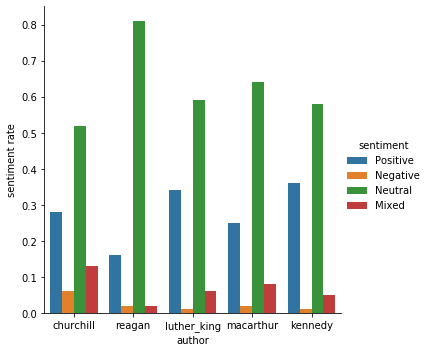

In [49]:
# Barplot dos resultados
sns_plot = sns.factorplot(x='author', y='sentiment rate', hue='sentiment', data=df_melt, kind='bar')
sns_plot.savefig("barplot.png", dpi=600, orientation ='landscape')

In [50]:
df

,Positive,Negative,Neutral,Mixed,author
churchill,0.28,0.06,0.52,0.13,churchill
reagan,0.16,0.02,0.81,0.02,reagan
luther_king,0.34,0.01,0.59,0.06,luther_king
macarthur,0.25,0.02,0.64,0.08,macarthur
kennedy,0.36,0.01,0.58,0.05,kennedy


In [51]:
df_t = df.drop('author', axis=1).T
df_t = df_t.reindex(index = ['Positive', 'Neutral', 'Negative', 'Mixed'])
df_t

,churchill,reagan,luther_king,macarthur,kennedy
Positive,0.28,0.16,0.34,0.25,0.36
Neutral,0.52,0.81,0.59,0.64,0.58
Negative,0.06,0.02,0.01,0.02,0.01
Mixed,0.13,0.02,0.06,0.08,0.05


/home/gabriel/miniconda3/envs/nlp_aws/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


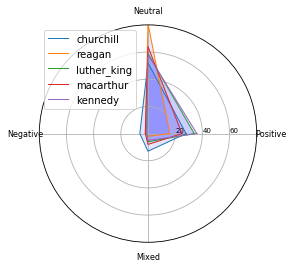

In [52]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
# number of variable
categories=['Positive', 'Neutral', 'Negative', 'Mixed']
colors = ['']
N = len(categories)
legend = []

for n in range(len(df_t.columns)):
    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values= df_t[df_t.columns[n]].tolist()
    values += values[:1]
    legend.append(df_t.columns[n])
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6, 0.8], ["20","40","60", ""], color="black", size=7)
    plt.ylim(0,0.80)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    
    # Add legend
    ax.legend(legend, loc='upper left')
    
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.savefig(f'{df_t.columns[n]}_radar.png', dpi=600, orientation='landscape', figsize=(16, 9))
    #plt.show()
    #plt.clf()


Bibliografia e Links
* Tutorial de reconhecimento de audio em Python https://realpython.com/python-speech-recognition/
* Tutorial de como baixar videos do Youtube usando linha de comando no Linux https://itsfoss.com/download-youtube-linux/
* Projeto Youtube-DL https://github.com/ytdl-org/youtube-dl/blob/master/README.md#readme
* Discurso “We Shall Fight on the Beaches” de Winston Churchill https://www.artofmanliness.com/we-shall-fight-on-the-beaches-by-winston-churchill/
* Discurso “Remarks at the Brandenburg Gate” de Ronald Regan https://www.artofmanliness.com/remarks-at-the-brandenburg-gate-by-ronald-regan/
* Discurso "I Have a Dream" de Martin Luther King https://kinginstitute.stanford.edu/king-papers/documents/i-have-dream-address-delivered-march-washington-jobs-and-freedom
* Discurso “What Matters More Than Your Talents” de Jeff Bezos https://jamesclear.com/great-speeches/what-matters-more-than-your-talents-by-jeff-bezos
* Discurso “Make Good Art” de Neil Gaiman https://jamesclear.com/great-speeches/make-good-art-by-neil-gaiman
* Tutorial de configuração de conta AWS e boto3 https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html#using-boto-3
* Tutorial de como lidar com Json no Python https://realpython.com/python-json/
* Curso de 'Natural Language Processing Fundamentals in Python' do DataCamp https://www.datacamp.com/courses/natural-language-processing-fundamentals-in-python

In [56]:
kennedy_original_transcript = "President Pitzer, Mr. Vice President, Governor, Congressman Thomas, Senator Wiley, and Congressman Miller, Mr. Webb, Mr. Bell, scientists, distinguished guests, and ladies and gentlemen: I appreciate your president having made me an honorary visiting professor, and I will assure you that my first lecture will be very brief. I am delighted to be here and I’m particularly delighted to be here on this occasion. We meet at a college noted for knowledge, in a city noted for progress, in a state noted for strength, and we stand in need of all three, for we meet in an hour of change and challenge, in a decade of hope and fear, in an age of both knowledge and ignorance. The greater our knowledge increases, the greater our ignorance unfolds. Despite the striking fact that most of the scientists that the world has ever known are alive and working today, despite the fact that this Nation’s own scientific manpower is doubling every 12 years in a rate of growth more than three times that of our population as a whole, despite that, the vast stretches of the unknown and the unanswered and the unfinished still far outstrip our collective comprehension. No man can fully grasp how far and how fast we have come, but condense, if you will, the 50,000 years of man’s recorded history in a time span of but a half-century. Stated in these terms, we know very little about the first 40 years, except at the end of them advanced man had learned to use the skins of animals to cover them. Then about 10 years ago, under this standard, man emerged from his caves to construct other kinds of shelter. Only five years ago man learned to write and use a cart with wheels. Christianity began less than two years ago. The printing press came this year, and then less than two months ago, during this whole 50-year span of human history, the steam engine provided a new source of power. Newton explored the meaning of gravity. Last month electric lights and telephones and automobiles and airplanes became available. Only last week did we develop penicillin and television and nuclear power, and now if America’s new spacecraft succeeds in reaching Venus, we will have literally reached the stars before midnight tonight. This is a breathtaking pace, and such a pace cannot help but create new ills as it dispels old, new ignorance, new problems, new dangers. Surely the opening vistas of space promise high costs and hardships, as well as high reward. So it is not surprising that some would have us stay where we are a little longer to rest, to wait. But this city of Houston, this state of Texas, this country of the United States was not built by those who waited and rested and wished to look behind them. This country was conquered by those who moved forward–and so will space. William Bradford, speaking in 1630 of the founding of the Plymouth Bay Colony, said that all great and honorable actions are accompanied with great difficulties, and both must be enterprised and overcome with answerable courage. If this capsule history of our progress teaches us anything, it is that man, in his quest for knowledge and progress, is determined and cannot be deterred. The exploration of space will go ahead, whether we join in it or not, and it is one of the great adventures of all time, and no nation which expects to be the leader of other nations can expect to stay behind in this race for space. Those who came before us made certain that this country rode the first waves of the industrial revolution, the first waves of modern invention, and the first wave of nuclear power, and this generation does not intend to founder in the backwash of the coming age of space. We mean to be a part of it–we mean to lead it. For the eyes of the world now look into space, to the moon and to the planets beyond, and we have vowed that we shall not see it governed by a hostile flag of conquest, but by a banner of freedom and peace. We have vowed that we shall not see space filled with weapons of mass destruction, but with instruments of knowledge and understanding. Yet the vows of this Nation can only be fulfilled if we in this Nation are first, and, therefore, we intend to be first. In short, our leadership in science and industry, our hopes for peace and security, our obligations to ourselves as well as others, all require us to make this effort, to solve these mysteries, to solve them for the good of all men, and to become the world’s leading space-faring nation. We set sail on this new sea because there is new knowledge to be gained, and new rights to be won, and they must be won and used for the progress of all people. For space science, like nuclear science and all technology, has no conscience of its own. Whether it will become a force for good or ill depends on man, and only if the United States occupies a position of pre-eminence can we help decide whether this new ocean will be a sea of peace or a new terrifying theater of war. I do not say that we should or will go unprotected against the hostile misuse of space any more than we go unprotected against the hostile use of land or sea, but I do say that space can be explored and mastered without feeding the fires of war, without repeating the mistakes that man has made in extending his writ around this globe of ours. There is no strife, no prejudice, no national conflict in outer space as yet. Its hazards are hostile to us all. Its conquest deserves the best of all mankind, and its opportunity for peaceful cooperation many never come again. But why, some say, the moon? Why choose this as our goal? And they may well ask why climb the highest mountain? Why, 35 years ago, fly the Atlantic? Why does Rice play Texas? We choose to go to the moon. We choose to go to the moon in this decade and do the other things, not because they are easy, but because they are hard, because that goal will serve to organize and measure the best of our energies and skills, because that challenge is one that we are willing to accept, one we are unwilling to postpone, and one which we intend to win, and the others, too. It is for these reasons that I regard the decision last year to shift our efforts in space from low to high gear as among the most important decisions that will be made during my incumbency in the office of the Presidency. In the last 24 hours we have seen facilities now being created for the greatest and most complex exploration in man’s history. We have felt the ground shake and the air shattered by the testing of a Saturn C-1 booster rocket, many times as powerful as the Atlas which launched John Glenn, generating power equivalent to 10,000 automobiles with their accelerators on the floor. We have seen the site where five F-1 rocket engines, each one as powerful as all eight engines of the Saturn combined, will be clustered together to make the advanced Saturn missile, assembled in a new building to be built at Cape Canaveral as tall as a 48 story structure, as wide as a city block, and as long as two lengths of this field. Within these last 19 months at least 45 satellites have circled the earth. Some 40 of them were made in the United States of America and they were far more sophisticated and supplied far more knowledge to the people of the world than those of the Soviet Union. The Mariner spacecraft now on its way to Venus is the most intricate instrument in the history of space science. The accuracy of that shot is comparable to firing a missile from Cape Canaveral and dropping it in this stadium between the 40-yard lines. Transit satellites are helping our ships at sea to steer a safer course. Tiros satellites have given us unprecedented warnings of hurricanes and storms, and will do the same for forest fires and icebergs. We have had our failures, but so have others, even if they do not admit them. And they may be less public. To be sure, we are behind, and will be behind for some time in manned flight. But we do not intend to stay behind, and in this decade, we shall make up and move ahead. The growth of our science and education will be enriched by new knowledge of our universe and environment, by new techniques of learning and mapping and observation, by new tools and computers for industry, medicine, the home as well as the school. Technical institutions, such as Rice, will reap the harvest of these gains. And finally, the space effort itself, while still in its infancy, has already created a great number of new companies, and tens of thousands of new jobs. Space and related industries are generating new demands in investment and skilled personnel, and this city and this state, and this region, will share greatly in this growth. What was once the furthest outpost on the old frontier of the West will be the furthest outpost on the new frontier of science and space. Houston, your city of Houston, with its Manned Spacecraft Center, will become the heart of a large scientific and engineering community. During the next 5 years the National Aeronautics and Space Administration expects to double the number of scientists and engineers in this area, to increase its outlays for salaries and expenses to $60 million a year; to invest some $200 million in plant and laboratory facilities; and to direct or contract for new space efforts over $1 billion from this center in this city. To be sure, all this costs us all a good deal of money. This year’s space budget is three times what it was in January 1961, and it is greater than the space budget of the previous eight years combined. That budget now stands at $5,400 million a year–a staggering sum, though somewhat less than we pay for cigarettes and cigars every year. Space expenditures will soon rise some more, from 40 cents per person per week to more than 50 cents a week for every man, woman and child in the United States, for we have given this program a high national priority–even though I realize that this is in some measure an act of faith and vision, for we do not now know what benefits await us. But if I were to say, my fellow citizens, that we shall send to the moon, 240,000 miles away from the control station in Houston, a giant rocket more than 300 feet tall, the length of this football field, made of new metal alloys, some of which have not yet been invented, capable of standing heat and stresses several times more than have ever been experienced, fitted together with a precision better than the finest watch, carrying all the equipment needed for propulsion, guidance, control, communications, food and survival, on an untried mission, to an unknown celestial body, and then return it safely to earth, re-entering the atmosphere at speeds of over 25,000 miles per hour, causing heat about half that of the temperature of the sun–almost as hot as it is here today–and do all this, and do it right, and do it first before this decade is out–then we must be bold. I’m the one who is doing all the work, so we just want you to stay cool for a minute. [laughter] However, I think we’re going to do it, and I think that we must pay what needs to be paid. I don’t think we ought to waste any money, but I think we ought to do the job. And this will be done in the decade of the Sixties. It may be done while some of you are still here at school at this college and university. It will be done during the terms of office of some of the people who sit here on this platform. But it will be done. And it will be done before the end of this decade. And I am delighted that this university is playing a part in putting a man on the moon as part of a great national effort of the United States of America. Many years ago the great British explorer George Mallory, who was to die on Mount Everest, was asked why did he want to climb it. He said, “Because it is there.” Well, space is there, and we’re going to climb it, and the moon and the planets are there, and new hopes for knowledge and peace are there. And, therefore, as we set sail we ask God’s blessing on the most hazardous and dangerous and greatest adventure on which man has ever embarked. Thank you."


In [63]:
ls

 barplot.png
"'Berlin Wall' Speech - President Reagan's Address at the Brandenburg Gate - 6_12_87-5MDFX-dNtsM.mp3"
 churchill_radar.png
 conda_env_nlp_aws.yaml
'Duty, Honor, Country _ Douglas MacArthur _ May 12, 1962 _ West Point-_42_aLGkRpg.mp3'
'I Have a Dream speech by Martin Luther King .Jr HD (subtitled) (Remastered)-vP4iY1TtS3s.mp3'
 kennedy_radar.png
 luther_king_radar.png
 macarthur_radar.png
 medium_article_study.ipynb
 NLP_usando_AWS.ipynb
 NLP_with_AWS_services.ipynb
 original_transcripts.json
 reagan_radar.png
"'We choose to go to the moon' Speech by President John F. Kennedy-QAmHcdwKgtQ.mp3"
'WE SHALL NEVER SURRENDER speech by Winston Churchill (We Shall Fight on the Beaches)-s_LncVnecLA.mp3'


In [64]:
with open('original_transcripts.json') as json_file:
    data = json.load(json_file)

In [ ]:
d